# Modélisation

### import bibliothèques

In [801]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, StratifiedKFold,cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
from statsmodels.api import OLS
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import pickle


### Importation du CSV et du dataframe nettoyé

In [802]:
df = pd.read_csv("csv/analyse_assurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges,grade
0,19,female,27.900,0,yes,southwest,16884.92400,underweight/good
1,18,male,33.770,1,no,southeast,1725.55230,overweight/obesity
2,28,male,33.000,3,no,southeast,4449.46200,overweight/obesity
3,33,male,22.705,0,no,northwest,21984.47061,underweight/good
4,32,male,28.880,0,no,northwest,3866.85520,underweight/good


## Train Test Split

On sépare l'ensemble de données en deux parties. Un pour l'entrainement et un pour l'évaluation. <br>
Cette méthode permet s'assurer que le modèle est robuste et peut généraliser des nouvelles données. 

In [803]:
X = df.drop(['charges'], axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.85, random_state=42 ,stratify=X[['smoker', 'grade']])

In [804]:
X_train.drop(['grade'], axis=1, inplace=True)
X_test.drop(['grade'], axis=1, inplace=True)

### modèle naif

Le modèle naïf, ne tient pas compte des caractéristiques des données. <br>
On l'utilise pour mesurer la performance d'un autre algorithme de prédiction. <br>
Si le modèle produit des prédictions significativement meilleures que le modèle naïf, cela signifie que les variables explicatives sont significativement corrélées à la variable cible et que le modèle est efficace.

In [805]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.0005478413375314961

### Encodage et Standardisation

On one hot encode les données pour convertir les variables catégorielles en variables numériques. <br>
On standardise les données afin de les adapter à une même échelle et ainsi réduire les effets des variations dans les unités des mesures. Cela contribue à améliorer la précision des prédictions et à faciliter la sélection des variables et des paramètres du modèle.  De plus, les différentes variables sont exprimées dans un espace de recherche plus réduit, ce qui conduit à une formation plus rapide du modèle.

In [806]:
transformer = make_column_transformer(
    (OneHotEncoder(),['sex','smoker','region']),
    (StandardScaler(),['age','children','bmi'])
    )

## Linear Regression

### Entrainement

In [807]:
lr_model = make_pipeline(transformer,PolynomialFeatures(2),LinearRegression())
lr_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'smoker', 'region']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

### Best Cross Validation

La validation en machine learning sert à évaluer la performance d'un modèle de machine learning construit sur des données d'entraînement. Elle permet de mesurer à quel point le modèle prédit correctement des données inconnues et de vérifier si le modèle généralise bien. La validation est essentielle pour régler le problème de sur-ajustement et pour évaluer la pertinence du modèle.

La cross validation est une méthode d'évaluation utilisée pour mesurer la performance des modèles de machine learning. Elle consiste à diviser l'ensemble de données en plusieurs sous-ensembles, qui sont alors utilisés séparément pour entraîner et tester le modèle. La cross validation est utile pour comparer et sélectionner le meilleur modèle, et pour évaluer sa performance et sa robustesse. Elle est également utile pour éviter le sur-ajustement des modèles en identifiant les caractéristiques qui sont le plus importantes pour leur performance.

In [808]:
def best_cross_val(model) :
    best_score = 0
    for k in range(2,21):
        cross_val = cross_validate(model, X_train, y_train, cv=k, scoring='r2')
        best_score = max(best_score,cross_val['test_score'].mean())
    return best_score

best_cross_val(lr_model)

0.848409724563089

In [816]:
y_pred = lr_model.predict(X_train)
residu = abs(y_pred-y_train)

### Erreur de Prédiction

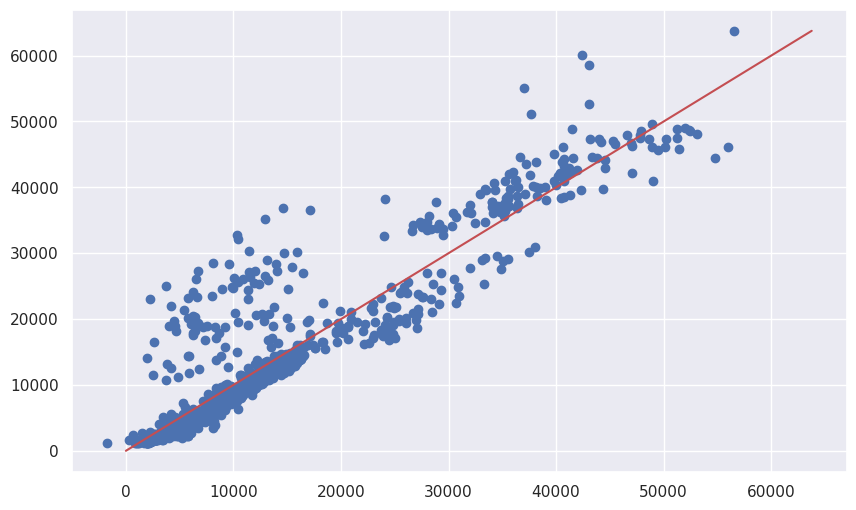

In [815]:
plt.subplots(figsize=(10, 6))
plt.scatter(y_pred,y_train)
plt.plot(np.arange(max(y_train.values)), np.arange(max(y_train.values)), color='r')
plt.show()

### Résidus

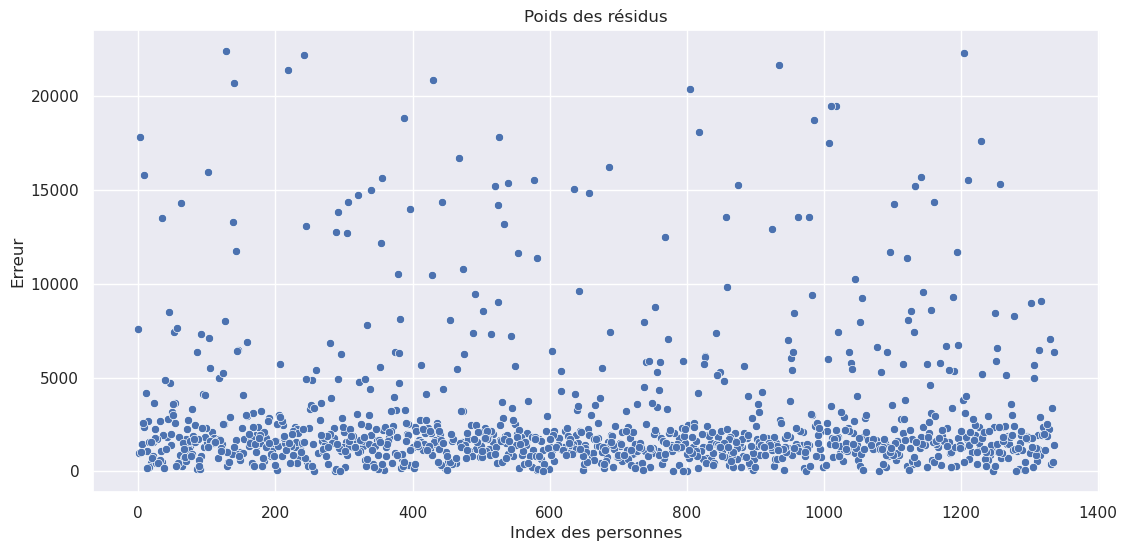

In [810]:
plt.figure(figsize=(13, 6))

sns.set(style="darkgrid")
sns.scatterplot(x=X_train.index,y=residu)

plt.title('Poids des résidus')
plt.ylabel('Erreur de prédiction sur charges')
plt.xlabel('Index des personnes')

plt.show()

## Distance de Cook

In [818]:
X_cook= transformer.transform(X_train)
X_cook_columns= transformer.get_feature_names_out()
newdf= pd.DataFrame(X_cook).set_index(y_train.index)
newdf.columns = X_cook_columns

X_cook=sm.add_constant(X_cook)
model_c = OLS(y_train , X_cook).fit()
influence = model_c.get_influence()
cooks_distance = influence.cooks_distance[0]

X_train['dcooks'] = cooks_distance
n= X_train.shape[0]
p = X_train.shape[1]
seuil_dcook = 4/n

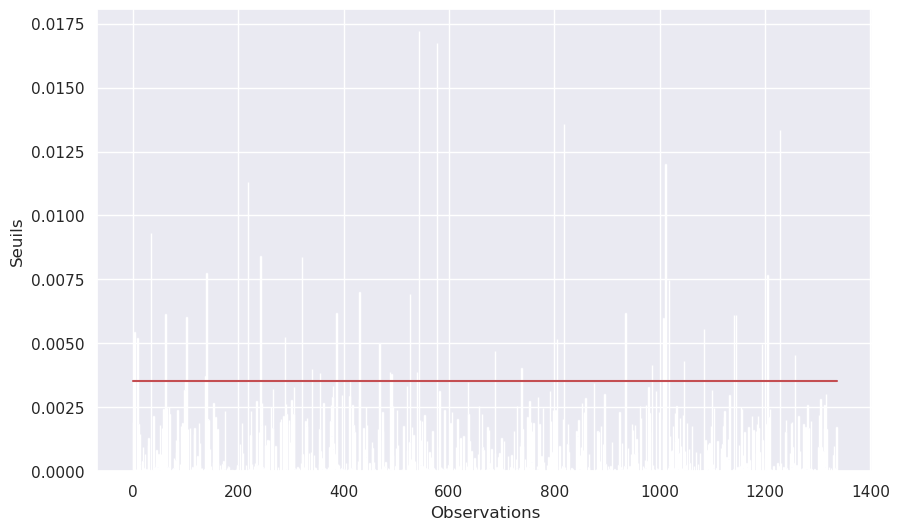

In [827]:
plt.figure(figsize=(10,6))
plt.bar(X_train.index, X_train['dcooks'] )
plt.xlabel('Observations')
plt.ylabel('Seuils')
plt.plot([0, len(df)], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [820]:
def cross_val_res(n_splits):
    scores = []
    data_size = len(X_train)
    indices = pd.Series(np.array_split(np.arange(data_size), n_splits))
    for k in range(n_splits):
        idx_train_split =[k for k in range(n_splits)]
        idx_train_split.remove(k)
        
        train_indices = [indice for indices in indices.loc[idx_train_split] for indice in indices]
        validation_indices = indices[k]
        
        X_train_res = X_train.iloc[train_indices]
        y_train_res = y_train.iloc[train_indices]
        
        residual_indice=X_train_res[X_train_res['dcooks']>seuil_dcook].index
        X_train_res.drop(residual_indice, inplace=True)
        y_train_res.drop(residual_indice, inplace=True)
        lr_model.fit(X_train_res, y_train_res)
        
        X_validation = X_train.iloc[validation_indices]
        y_validation = y_train.iloc[validation_indices]
        score = lr_model.score(X_validation,y_validation)
        scores.append(score)
    return np.array(scores).mean()

def best_cross_val_res() :
    best_score = 0
    for k in range(2,21):
        best_score = max(best_score,cross_val_res(k))
    return best_score

best_cross_val_res()

/tmp/ipykernel_173933/2205262509.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_res.drop(residual_indice, inplace=True)
/tmp/ipykernel_173933/2205262509.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_res.drop(residual_indice, inplace=True)
/tmp/ipykernel_173933/2205262509.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_res.drop(residual_indice, inplace=True)
/tmp/ipykernel_173933/2205262509.py:1

0.8484985613448506

In [ ]:
cross_val=cross_validate(lr_model, X_train, y_train,scoring='neg_root_mean_squared_error' ,cv=5)
cross_val['test_score'].mean()

-4649.255879166315

In [ ]:
grid.fit(X_train, y_train)
best_model= grid.best_estimator_
grid.best_score_

0.8977273733746586

In [ ]:
best_model[:-1].get_feature_names_out()

array(['1', 'onehotencoder__sex_female', 'onehotencoder__sex_male',
       'onehotencoder__smoker_no', 'onehotencoder__smoker_yes',
       'onehotencoder__region_northeast',
       'onehotencoder__region_northwest',
       'onehotencoder__region_southeast',
       'onehotencoder__region_southwest', 'standardscaler__age',
       'standardscaler__children', 'standardscaler__bmi',
       'onehotencoder__sex_female^2',
       'onehotencoder__sex_female onehotencoder__sex_male',
       'onehotencoder__sex_female onehotencoder__smoker_no',
       'onehotencoder__sex_female onehotencoder__smoker_yes',
       'onehotencoder__sex_female onehotencoder__region_northeast',
       'onehotencoder__sex_female onehotencoder__region_northwest',
       'onehotencoder__sex_female onehotencoder__region_southeast',
       'onehotencoder__sex_female onehotencoder__region_southwest',
       'onehotencoder__sex_female standardscaler__age',
       'onehotencoder__sex_female standardscaler__children',
       'o

In [ ]:
coef=best_model[-1].coef_
coef

array([ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -2.30860379e+04,
        0.00000000e+00,  4.97056774e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  3.41784247e+03,  5.65013433e+02,  2.85396040e+02,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -2.37345399e+02,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.02409226e+02, -3.79330541e+02,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.08636247e+02,  9.87050710e+01,
        5.83517211e+01,  0.00000000e+00,  3.11602845e+01,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  8.06858341e+03,  6.52479842e+02,  0.00000000e+00,
        0.00000000e+00,  

In [ ]:
coef_df= pd.DataFrame(coef, columns=['coef'] ,index=best_model[:-1].get_feature_names_out())
coef_df

,coef
1,0.000000
onehotencoder__sex_female,0.000000
onehotencoder__sex_male,-0.000000
onehotencoder__smoker_no,-23086.037905
onehotencoder__smoker_yes,0.000000
...,...
standardscaler__age standardscaler__children,-0.000000
standardscaler__age standardscaler__bmi,0.000000
standardscaler__children^2,-0.000000
standardscaler__children standardscaler__bmi,-0.000000


In [ ]:
coef_df[coef_df['coef'] != 0].shape[0]

18

In [ ]:
coef_df[coef_df['coef'] != 0]


,coef
onehotencoder__smoker_no,-23086.037905
onehotencoder__region_northeast,4.970568
standardscaler__age,3417.842469
standardscaler__children,565.013433
standardscaler__bmi,285.396040
onehotencoder__sex_male onehotencoder__smoker_no,-237.345399
onehotencoder__sex_male standardscaler__bmi,102.409226
onehotencoder__smoker_no^2,-379.330541
onehotencoder__smoker_no onehotencoder__region_southwest,-108.636247
onehotencoder__smoker_no standardscaler__age,98.705071


In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = newdf.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [vif(newdf, i) for i in range(len(newdf.columns))]

print(vif_data)

# newdf

                            feature       VIF
0         onehotencoder__sex_female       inf
1           onehotencoder__sex_male       inf
2          onehotencoder__smoker_no       inf
3         onehotencoder__smoker_yes       inf
4   onehotencoder__region_northeast       inf
5   onehotencoder__region_northwest       inf
6   onehotencoder__region_southeast       inf
7   onehotencoder__region_southwest       inf
8               standardscaler__age  1.016204
9          standardscaler__children  1.005155
10              standardscaler__bmi  1.110533


/home/apprenant/miniconda3/envs/env_analyse/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [ ]:
with open('model.pkl', 'wb') as file:
  pickle.dump(best_model, file)

## ElasticNet

### Entrainement

In [ ]:
elastic_model = make_pipeline(transformer,PolynomialFeatures(),ElasticNet(random_state=42 ))
elastic_model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['sex', 'smoker', 'region']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'children',
                                                   'bmi'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('elasticnet', ElasticNet(random_state=42))])

In [ ]:
best_cross_val(elastic_model)

0.7612186517798696

Nous obtenons une score de 65 , après la cross validation, pour notre modele avec les valeurs par defaut des paramètres de notre modele.

#### Utilisation d'un RandomizeSearch afin d'avoir un ordre d'idée de l'hyperparamètre d'ElasticNet à modifier pour améliorer notre model

In [ ]:
param_search = {'elasticnet__alpha':np.linspace(0,100,500),'elasticnet__l1_ratio':[1],'polynomialfeatures__degree':[1,2]}
random_search = RandomizedSearchCV(model, param_distributions=param_search, n_iter=100, cv=5, random_state=42)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

/home/apprenant/miniconda3/envs/env_analyse/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.935e+07, tolerance: 1.397e+07
  model = cd_fast.enet_coordinate_descent(


{'polynomialfeatures__degree': 2, 'elasticnet__l1_ratio': 1, 'elasticnet__alpha': 97.39478957915831}


#### Utilisation d'un GridSearch afin d'obtenir l'hyperparamètre d'ElasticNet( centré autour de la valeur donnée par le RandomizeSearch) le plus efficient

In [ ]:
params = {'elasticnet__alpha':np.linspace(82,87,100)}
grid=GridSearchCV(random_search.best_estimator_, param_grid=params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'children',
                                                                          'bmi'])])),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('elasticnet',
                                        ElasticNet(alpha=97.39478957915831,
                                                   l1_ratio=1,
                                                   random_state=42))]),
             param...
       85.53535354, 85.58585859, 85.63636364, 85.68686869, 85.73737374,
       85.78787879, 85.83838384, 85.88888889, 85.93939394, 85.98989899,
       86.04040404, 86.09090909, 86.14141414, 86.19191919, 86.24242424,
       86.29292929, 86.34343434, 86.39393939, 86.44444444, 86.49494949,
       86.54545455, 86.5959596 , 86.64646465, 86.6969697 , 86.74747475,
       86.7979798 , 86.84848485, 86.8989899 , 86.94949495, 87.        ])},
             scoring='r2')

Valeur de l'hyperparamètre alpha déterminée grâce au GridSearch

In [ ]:
grid.best_params_

{'elasticnet__alpha': 87.0}

Application du meilleur hyperparamètre (trouvé) à notre model 

In [ ]:
best_model= grid.best_estimator_
grid.best_score_

0.8256115371739974

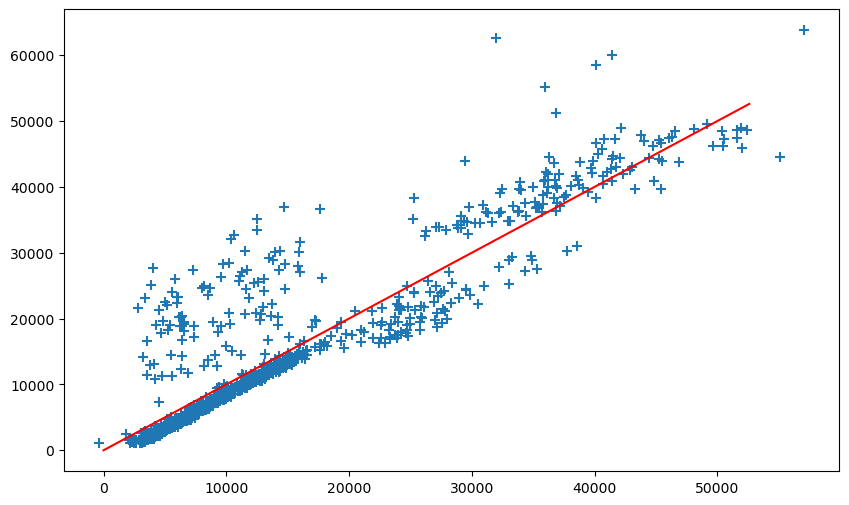

In [ ]:
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_train)
plt.subplots(figsize=(10, 6))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()


#### Présentation des scores R2 de notre modèle

In [ ]:
best_model.score(X_train,y_train)

0.8339387125448297

Après l'application des hyperparamètres, on peut observer que notre modele s'est bien améliorer! On obtient un score de 80!

## Utilsation de la regression lineaire afin de comparer avec notre model ElasticNet

In [ ]:
# onehot = OneHotEncoder(drop="if_binary")
# std = StandardScaler()
# num_pipe = make_pipeline(StandardScaler(),)
# onehot_col_std = make_column_transformer(
#     (onehot, ['sex', 'region', 'smoker', 'grade']),
#     (num_pipe, ['age',  'children'])
#     )
# preprocessing_poly_std = make_pipeline(onehot_col_std, PolynomialFeatures())
# lr = LinearRegression()
# # lr_pipe = make_pipeline(preprocessing_poly, lr)
# lr_pipe_std = make_pipeline(preprocessing_poly_std, lr)
# lr_pipe_std.fit(X_train, y_train)
# cross_validate(lr_pipe_std, X_train, y_train, cv=5)['test_score'].mean()